In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
from sklearn.preprocessing import StandardScaler
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.lstm import create_data

2024-05-15 22:12:54.621213: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 22:12:54.652745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 22:12:54.652773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 22:12:54.653555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 22:12:54.658840: I tensorflow/core/platform/cpu_feature_guar

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "period"
target_column = "value"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column, "value_30_hours_ago"]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

In [3]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(11467, 2)

In [4]:

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    scaled_data,
    n_future=1,
    n_past=30,
    train_test_split_percentage=0.9,
    validation_split_percentage=0,
)

In [5]:
X_test[0]

array([[-0.0984837 , -0.19466005],
       [-0.29308211, -0.14025653],
       [-0.54916406, -0.05705241],
       [-0.76821518,  0.0199695 ],
       [-0.91137122,  0.02346565],
       [-1.01922325, -0.03279253],
       [-1.07996064, -0.14552208],
       [-1.0515213 , -0.33471926],
       [-0.91548576, -0.56529467],
       [-0.63663528, -0.77480791],
       [-0.35087749, -0.93746419],
       [-0.24242853, -1.06594773],
       [-0.19635851, -1.11824077],
       [-0.15497863, -1.08679673],
       [-0.1379662 , -0.93641961],
       [-0.14058841, -0.62931261],
       [-0.11332161, -0.35392678],
       [-0.08588426, -0.25974388],
       [-0.06373398, -0.19075886],
       [ 0.01205451, -0.14524494],
       [ 0.1295853 , -0.11360904],
       [ 0.19863703, -0.11738233],
       [ 0.20733512, -0.10542293],
       [ 0.14252584, -0.08404099],
       [ 0.00160828, -0.06329858],
       [-1.16856176, -0.02816653],
       [-0.47241622,  0.0645241 ],
       [-0.69417484,  0.12351099],
       [-0.93968265,

In [6]:
import json

def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )

        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=1000,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )
        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [7]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [64, 128, 256],
    [24, 7*24],
    [0.2],
]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)

[(True, True, True, 64, 24, 0.2), (True, True, True, 64, 168, 0.2), (True, True, True, 128, 24, 0.2), (True, True, True, 128, 168, 0.2), (True, True, True, 256, 24, 0.2), (True, True, True, 256, 168, 0.2), (True, True, False, 64, 24, 0.2), (True, True, False, 64, 168, 0.2), (True, True, False, 128, 24, 0.2), (True, True, False, 128, 168, 0.2), (True, True, False, 256, 24, 0.2), (True, True, False, 256, 168, 0.2), (True, False, True, 64, 24, 0.2), (True, False, True, 64, 168, 0.2), (True, False, True, 128, 24, 0.2), (True, False, True, 128, 168, 0.2), (True, False, True, 256, 24, 0.2), (True, False, True, 256, 168, 0.2), (True, False, False, 64, 24, 0.2), (True, False, False, 64, 168, 0.2), (True, False, False, 128, 24, 0.2), (True, False, False, 128, 168, 0.2), (True, False, False, 256, 24, 0.2), (True, False, False, 256, 168, 0.2), (False, True, True, 64, 24, 0.2), (False, True, True, 64, 168, 0.2), (False, True, True, 128, 24, 0.2), (False, True, True, 128, 168, 0.2), (False, True, T

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.27289

Epoch 3: val_loss improved from 0.27289 to 0.23024, saving model to best_model.h5

Epoch 4: val_loss improved from 0.23024 to 0.22059, saving model to best_model.h5

Epoch 5: val_loss improved from 0.22059 to 0.17785, saving model to best_model.h5

Epoch 6: val_loss improved from 0.17785 to 0.17061, saving model to best_model.h5

Epoch 7: val_loss improved from 0.17061 to 0.12951, saving model to best_model.h5

Epoch 8: val_loss improved from 0.12951 to 0.10415, saving model to best_model.h5

Epoch 9: val_loss improved from 0.10415 to 0.08069, saving model to best_model.h5

Epoch 10: val_loss improved from 0.08069 to 0.06503, saving model to best_model.h5

Epoch 11: val_loss improved from 0.06503 to 0.05866, saving model to best_model.h5

Epoch 12: val_loss did not improve from 0.05866

Epoch 13: val_loss did not improve from 0.05866

Epoch 14: val_loss improved from 0.05866 to 0.04905, saving model to best_model.h5

Epoch 15: val_loss d

KeyboardInterrupt: 

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)

In [5]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = list(hist.iloc[0, :-2])

In [18]:
list(hist.iloc[0, :-2])

[True, True, True, 256, 168, 0.2]


In [7]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.33921, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.33921 to 0.24867, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.24867

Epoch 4: val_loss improved from 0.24867 to 0.24148, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.24148

Epoch 6: val_loss improved from 0.24148 to 0.23889, saving model to best_model.h5

Epoch 7: val_loss improved from 0.23889 to 0.19393, saving model to best_model.h5

Epoch 8: val_loss improved from 0.19393 to 0.18328, saving model to best_model.h5

Epoch 9: val_loss improved from 0.18328 to 0.15291, saving model to best_model.h5

Epoch 10: val_loss improved from 0.15291 to 0.13593, saving model to best_model.h5

Epoch 11: val_loss improved from 0.13593 to 0.11805, saving model to best_model.h5

Epoch 12: val_loss improved from 0.11805 to 0.11637, saving model to best_model.h5

Epoch 13: val_loss did not improve from 0.11637

Epoch 14: val_loss improved from 0.11637 to 0.10412, saving model to best_model.h5

Epoch 15: val_loss i

In [8]:
regressor.evaluate(X_test, y_test)

36/36 [==============================] - 2s 44ms/step - loss: 0.0165


0.016466191038489342

In [9]:
y_pred = regressor.predict(X_test)

36/36 [==============================] - 3s 44ms/step


In [10]:
non_zero = []
scaler = StandardScaler()
scaler.fit(df[[target_column]])
unscaled_y_pred = scaler.inverse_transform([y_pred.flatten()])[0]
unscaled_y_test = scaler.inverse_transform([y_test.flatten()])[0]
unscaled_y_train = scaler.inverse_transform([y_train.flatten()])[0]
for i in unscaled_y_pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

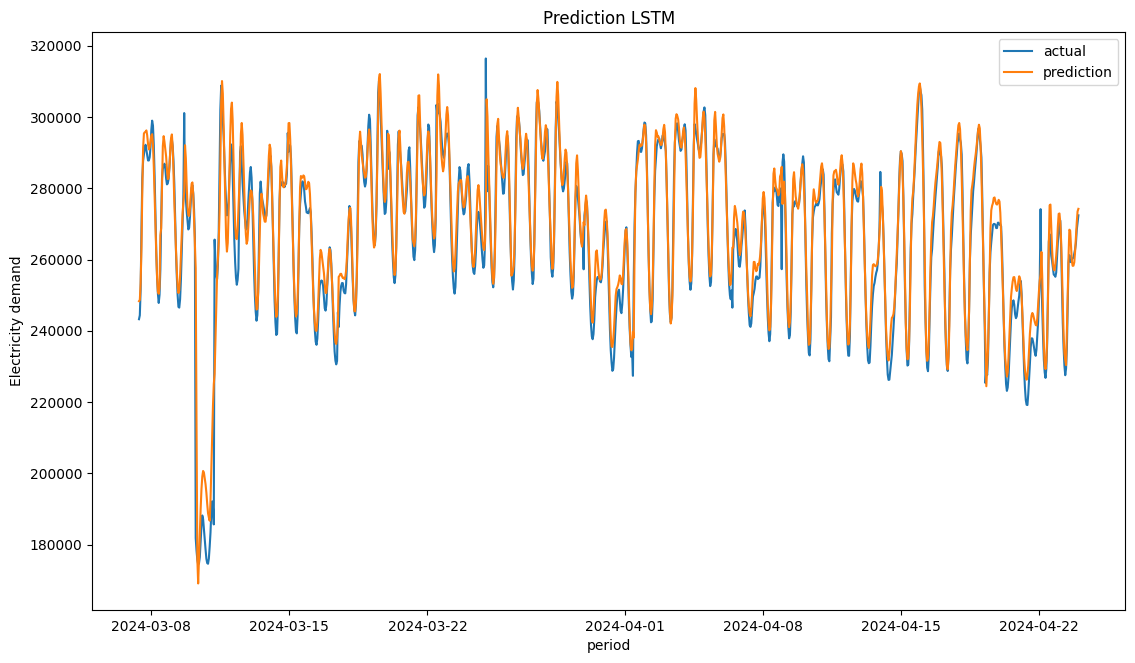

In [11]:


import matplotlib.dates as mdates
data_length = len(unscaled_y_test)

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(pd.to_datetime(dates[-data_length:]), unscaled_y_test-1, label="actual")
ax.plot(pd.to_datetime(dates[-data_length:]), non_zero, label="prediction")
ax.set_title("Prediction LSTM")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

In [12]:
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test-1, unscaled_y_train-1)

Evaluation Metrics:
MSE: 36234292.31
RMSE: 6019.49
MAE: 3959.24
MAPE: 1.55
SMAPE: 1.53
MASE: 0.54


In [13]:
store_model(regressor, "lstm")